File exists: True
original size of images: (250, 337) (250, 337)


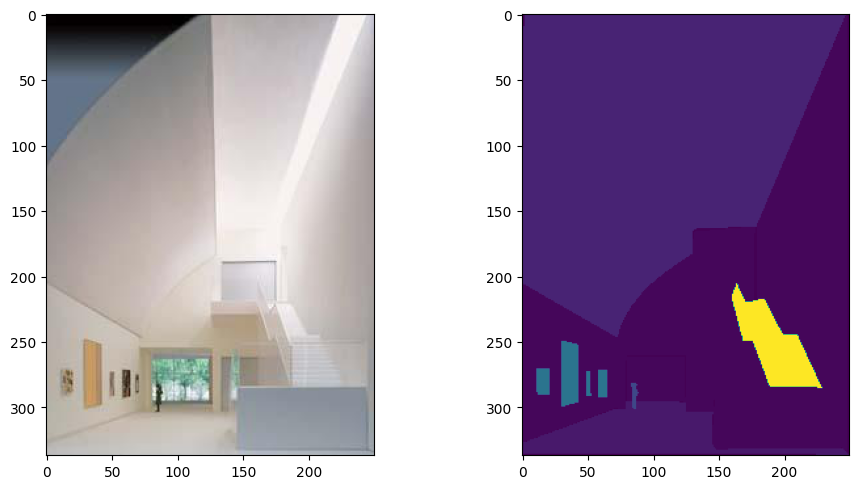

size after passing through __getitem__: torch.Size([3, 480, 480]) torch.Size([1, 480, 480])


In [9]:
import torch.utils.data as data
from torch.utils.data import DataLoader
import os
import glob
import torch
import pathlib
from torchvision import transforms
from matplotlib import pyplot as plt
from pathlib import Path
import PIL.Image

# modified from https://discuss.pytorch.org/t/loading-ade20k-dataset/48684/2
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path):
        super(DataLoaderSegmentation, self).__init__()
        self.img_files = glob.glob(os.path.join(folder_path,'images','training','*.jpg'))
        self.mask_files = []
        for img_path in self.img_files:
             # we use `pathlib.Path(img_path).stem` to extract only the file name
             self.mask_files.append(os.path.join(folder_path,'annotations','training',pathlib.Path(img_path).stem + ".png")) 

        # apparently this is necessary     
        self.transforms = transforms.Compose(
            [
                transforms.Resize(size=(480, 480)),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.to(torch.float32)),
            ]
        )

    def __getitem__(self, index, observe=False):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = PIL.Image.open(img_path)
            label = PIL.Image.open(mask_path)
            if observe is True:
                # Displaying images (optional for debugging)
                print(f'original size of images:',data.size, label.size)  # Check image dimensions
                plt.figure(figsize=(10,5))
                plt.subplot(1,2,1)
                plt.imshow(data)
                
                plt.subplot(1,2,2)
                plt.imshow(label)
                plt.tight_layout()
                plt.show()
            return self.transforms(data), self.transforms(label)

    def __len__(self):
        return len(self.img_files)



folder_path = Path('./data/mseg_dataset/ADEChallengeData2016')
print(f"File exists: {folder_path.exists()}")
loader = DataLoaderSegmentation(folder_path=folder_path)

data_loader = DataLoader(loader,num_workers=4, batch_size=2, shuffle=False, pin_memory=True)

image_loader, label_loader = loader.__getitem__(10,observe=True)

print('size after passing through __getitem__:',image_loader.shape,label_loader.shape)


In [ ]:
# Define output head for semantic segmentation task: "We use an output head that predicts at half resolution and upsamples the logits to full resolution using bilinear interpolation" 




In [ ]:
# define my DPT class
import lightning as L
from DPT import DPT

class ModelDPT(L.LightningModule):
    def __init__():
        super().__init__()

        self.dpt = DPT


    def training_step():
        pass 

    def configure_optimizers():
        # We use a cross-entropy loss 
        pass         

    dpt = ModelDPT()


In [ ]:


trainer = L.Trainer()
trainer.fit(model= ,train_dataloaders=data_loader)